#Ordinal Logistic Regression for EMA Values in Aqualab

Through an iteration over Pearson correlation coefficients in the Aqualab feature data, I've previously identified some feature values with loose(>0.2) correlations. I then used ordinal logistic regression to test some cases in which binary explanatory per-job features(level has been completed, etc.) have strong correlations to the ordinal dependent features(Evaluation, Modeling, Argumentation). Jobs that have been specifically identified as having strong explanatory power include:


*   Job 12
*   Job 13
*   Job 32

We are now going to take a systematic approach to using ordinal logistic regression to look for further correlations in the data. We will also validate the relationships between variables, and convert continuous variables(ex. percent complete) to binary(ex. hasAttempted)

### Data/Module Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rfpimp
!pip install mord
!pip install pypair
!pip install phik
!pip install MASS

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=45928c7c7680a93b4ef1170a3f6a2cd2ccc15396ea8db06c5e3b745bc613e8dc
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=a03f8f84406f0a3ed255f40550e09fdf4a73e72a741aa184d05b0ef04591e8f1
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... do

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix

from scipy.stats import kendalltau

import scipy.stats as stats

import sklearn
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from tensorflow import keras
from sklearn import linear_model
from scipy.stats import chi2


import statsmodels.api as sm

import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from pypair.association import binary_continuous


import json
import urllib.request as ur
from collections import Counter
from io import BytesIO
from math import ceil, pi
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
from mord import LogisticAT

import statsmodels.api as sm





In [ ]:
## Load in feature values and columns from tsv

ply_features = pd.read_csv("/content/drive/MyDrive/AqualabValidation_Zach/featuredata/AQUALAB_20220601_to_20220715_c2ad3af_player-features.tsv", sep = "	").dropna()
#remove NA values
ply_features = ply_features.loc[ply_features.PlayerID.isna() != True]

id_col = ['PlayerID']
job_col = []
aggr_col = []
for col in ply_features.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job'):
    job_col.append(pieces[1])
  else:
    aggr_col.append(col)
job_col = Counter(job_col)
print(f"{len(ply_features.columns)} perjobfeatures in {len(job_col)} groups:")
pprint(job_col, compact=False)

job_col = [key for key in job_col.keys() if key.startswith('Job')]
aggr_col = aggr_col[1:]
pprint(aggr_col)


1272 perjobfeatures in 22 groups:
Counter({'JobActiveTime': 57,
         'JobArgumentationTime': 57,
         'JobCompletionTime': 57,
         'JobDiveSitesCount': 57,
         'JobDiveTime': 57,
         'JobExperimentationTime': 57,
         'JobGuideCount': 57,
         'JobHelpCount': 57,
         'JobHelpCount-ByTask': 57,
         'JobLocationChanges': 57,
         'JobLocationChanges-ByTask': 57,
         'JobModelingTime': 57,
         'JobTasksCompleted': 57,
         'SyncCompletionTime': 57,
         'JobsAttempted': 57,
         'JobsAttempted-job-name': 57,
         'JobsAttempted-num-starts': 57,
         'JobsAttempted-num-completes': 57,
         'JobsAttempted-percent-complete': 57,
         'JobsAttempted-avg-time-per-attempt': 57,
         'JobsAttempted-std-dev-per-attempt': 57,
         'JobsAttempted-job-difficulties': 57})
['ActiveTime',
 'JobsCompleted',
 'SessionDiveSitesCount',
 'SessionDuration',
 'SessionGuideCount',
 'SessionHelpCount',
 'SessionID',
 'Ses

In [ ]:
# import job complexity scores
DBexport = json.load(open("/content/drive/MyDrive/AqualabValidation_Zach/DBExport.json"))
Complexity_df = pd.DataFrame(columns=['job_id', 'job_name', 'argumentation', 'experimentation', 'modeling'])
for id, job in enumerate(DBexport.get('jobs')):
  Complexity_df.loc[len(Complexity_df.index)] = [id, job['id'], job['difficulties']['argumentation'],
                                                 job['difficulties']['experimentation'],
                                                 job['difficulties']['modeling']]

# import player complexity scores
labels = pd.read_excel("/content/drive/MyDrive/AqualabValidation_Zach/surveydata/Aqualab Practices Survey June 2022 scores final.xlsx",
                       sheet_name='Simplified')
labels = labels.rename({'Modeling_score_max_5)':'Modeling_score_max_5'}, axis='columns')

player_complexity = pd.merge(ply_features, labels, left_on="PlayerID", right_on="user_code", how="inner")


### EMA Correlations Visualizations

As a reminder, here are histograms and summary data for the distributions of EMA complexity scores

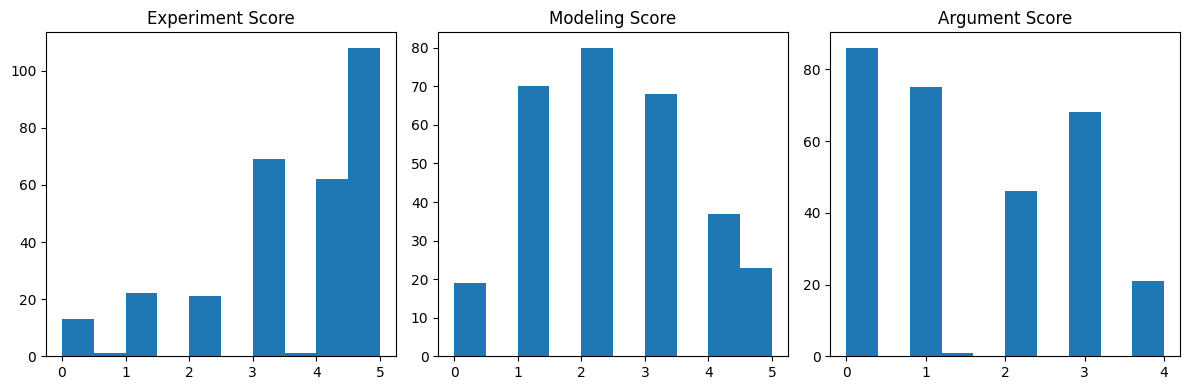

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = labels['Experiment_score_max_5']
modeling_score = labels['Modeling_score_max_5']
argument_score = labels['Argument_score_max_4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

## Re-calculating correlation coefficients
Since we're looking at a binary variable against an ordinal variable, let's use the point-biserial correlation coefficient and filter for statistically significant correlations. To give us a smaller starting point, we'll use an alpha of 0.01. Notice that we've identified many of the same job features as last time.

In [ ]:
df = player_complexity

correlation_columns = ['Experiment_score_max_5', 'Modeling_score_max_5', 'Argument_score_max_4']

for job in df:
  if "Job" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.01:
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}')


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


job12_JobActiveTime: 0.24153438390057475, 0.001558214137636143
job13_JobActiveTime: 0.2409400674576925, 0.0016017094749440168
job20_JobActiveTime: 0.22221512072178157, 0.003687205291242592
job32_JobActiveTime: 0.26897793932324604, 0.0004059916330923243
job32_JobActiveTime: 0.24290622562645434, 0.001461900487751106
job36_JobActiveTime: 0.20652764192732975, 0.007059149213824686
job36_JobDiveSitesCount: 0.19964426387207776, 0.009258312618162979
job12_JobHelpCount: 0.20929603847070571, 0.006314843529341373
job13_JobHelpCount: 0.20486749766428836, 0.007542041326720494
job15_JobHelpCount: 0.20486749766428838, 0.007542041326720494
job24_JobHelpCount: -0.2430131642629367, 0.0014546259213001022
job32_JobHelpCount: 0.2171015186079354, 0.004578696462998041
job12_JobTasksCompleted: 0.27596723117702604, 0.0002815261453787398
job13_JobTasksCompleted: 0.26122532016646816, 0.0006024977234329746
job15_JobTasksCompleted: 0.23031542931683946, 0.0025911818517876904
job32_JobTasksCompleted: 0.2273529232433

In [1]:
mod_prob = OrderedModel(df['Modeling_score_max_5'],
                        df[['job32_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

NameError: ignored

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4'],
                        df[['job13_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs', disp=False)
res_prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     Argument_score_max_4   Log-Likelihood:                -245.60
Model:                     OrderedModel   AIC:                             501.2
Method:              Maximum Likelihood   BIC:                             516.9
Date:                  Tue, 20 Jun 2023                                         
Time:                          00:38:43                                         
No. Observations:                   169                                         
Df Residuals:                       164                                         
Df Model:                             5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job13_JobTasksCompleted     2.0304      0.607      3.348      0.001       0.842       3.219
0.0/1.0                    -0.8501      0.173     -4.918      0.000      -1.189      -0.511
1.0/2.0                     0.2699      0.125      2.162      0.031       0.025       0.515
2.0/3.0                    -0.4889      0.202     -2.421      0.015      -0.885      -0.093
3.0/4.0                     0.6834      0.164      4.163      0.000       0.362       1.005
===========================================================================================
"""

In [ ]:
model = sm.GLM.from_formula("job12_JobTasksCompleted ~ Modeling_score_max_5", family=sm.families.Binomial(), data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     job12_JobTasksCompleted   No. Observations:                  169
Model:                                 GLM   Df Residuals:                      167
Model Family:                     Binomial   Df Model:                            1
Link Function:                       Logit   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -46.029
Date:                     Tue, 20 Jun 2023   Deviance:                       92.059
Time:                             01:01:24   Pearson chi2:                     165.
No. Iterations:                          6   Pseudo R-squ. (CS):            0.02623
Covariance Type:                 nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.5230      0.664     -5.305      0.000      -4.824      -2.222
Modeling_score_max_5     0.4319      0.206      2.098      0.036       0.028       0.836
========================================================================================
"""

In [ ]:
log_reg = smf.logit("job15_JobHelpCount ~ Argument_score_max_4", data=df).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.132573
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     job15_JobHelpCount   No. Observations:                  169
Model:                          Logit   Df Residuals:                      167
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Jun 2023   Pseudo R-squ.:                  0.1356
Time:                        01:40:20   Log-Likelihood:                -22.405
converged:                       True   LL-Null:                       -25.921
Covariance Type:            nonrobust   LLR p-value:                  0.008005
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.2954      1.176     -4.502      0.000      -7.601      -2.990
Argument_score_max_4     0.9203      0.395      2.330      0.020       0.146       1.695
========================================================================================
"""

Text(0, 0.5, 'job15_JobHelpCount')

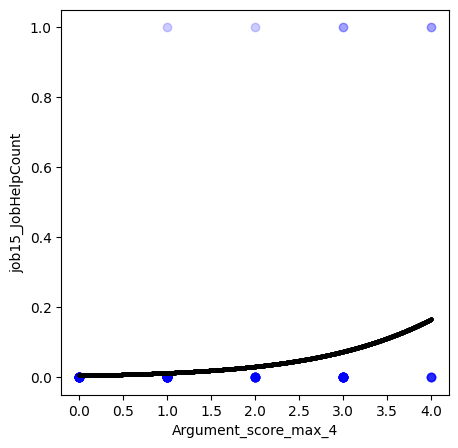

In [ ]:
compNew = pd.DataFrame({'Argument_score_max_4': np.linspace(df["Argument_score_max_4"].min(), df["Argument_score_max_4"].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df["Argument_score_max_4"], df["job15_JobHelpCount"], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel('Argument_score_max_4')
ax.set_ylabel('job15_JobHelpCount')
# plt.savefig('img/diabetesGlucosePreds.png')



In [ ]:
log_reg.pred_table(threshold=0.5)


array([[163.,   0.],
       [  6.,   0.]])

In [ ]:
sns.regplot(df["Argument_score_max_4"], df["job13_JobTasksCompleted"], data=df, logistic=True, ci=None)

TypeError: ignored

# Good Models?

In [ ]:
log_reg_2 = smf.logit("job15_JobHelpCount ~ Argument_score_max_4", data=df).fit()
log_reg_2.summary()

Optimization terminated successfully.
         Current function value: 0.132573
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     job15_JobHelpCount   No. Observations:                  169
Model:                          Logit   Df Residuals:                      167
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Jun 2023   Pseudo R-squ.:                  0.1356
Time:                        01:36:24   Log-Likelihood:                -22.405
converged:                       True   LL-Null:                       -25.921
Covariance Type:            nonrobust   LLR p-value:                  0.008005
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.2954      1.176     -4.502      0.000      -7.601      -2.990
Argument_score_max_4     0.9203      0.395      2.330      0.020       0.146       1.695
========================================================================================
"""